In [1]:
import CMGDB

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import numpy as np
import math
import csv

In [2]:
# Define a Gaussian process
def GP(X_train, Y_train):
    # fit Gaussian Process with dataset X_train, Y_train
    kernel = RBF(0.5, (0.01, 2)) + WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, Y_train)
    return gp

In [3]:
# Load data from file
data = np.loadtxt('PO_50.dat')
# data = np.loadtxt('PO_100.dat')

# Get X and Y vectors
X = data[:, [0,1]]
Y = data[:, [2,3]]

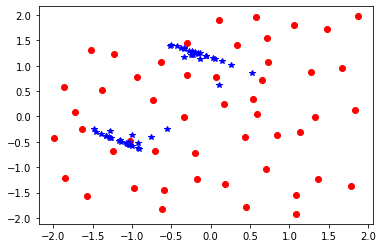

In [4]:
# Plot data
plt.plot(X[:,0], X[:,1], 'ro', Y[:,0], Y[:,1], 'b*');

In [5]:
# Train a GP with the data above
gp = GP(X, Y)

In [6]:
# Use the GP to define a map F
# Notice that the GP takes lists as
# input and output, so we need to
# add the [] below
def F(X):
    return gp.predict([X])[0]

Now we can use the map F above to compute the Morse graph

In [7]:
# Define the parameters for CMGDB
lower_bounds = [-2.0, -2.0]
upper_bounds = [2.0, 2.0]

subdiv_min = 20
subdiv_max = 30

morse_fname = 'morse_sets.csv'

In [8]:
%%time
morse_graph = CMGDB.MorseGraphMap(subdiv_min, subdiv_max, lower_bounds,
                                  upper_bounds, morse_fname, F)

CPU times: user 4.34 s, sys: 79.5 ms, total: 4.42 s
Wall time: 4.49 s


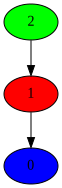

In [9]:
# Plot Morse graph
CMGDB.PlotMorseGraph(morse_graph)

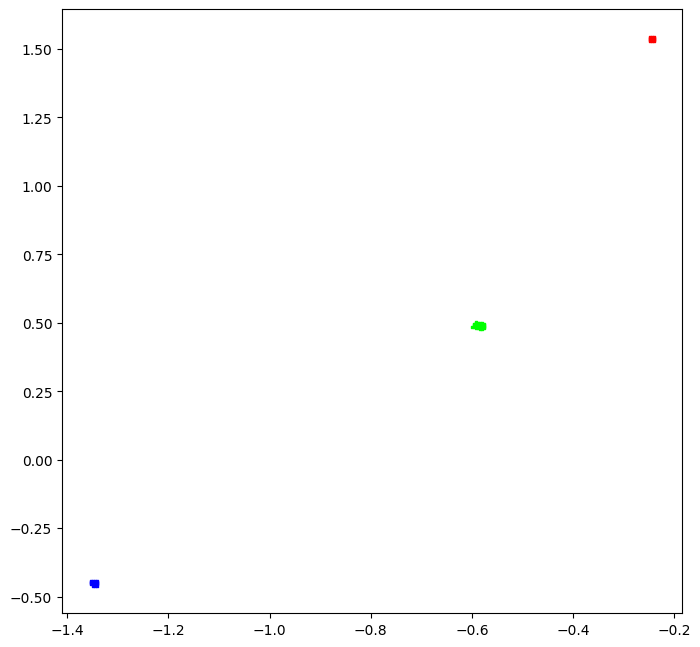

In [10]:
# Plot Morse sets
CMGDB.PlotMorseSets(morse_fname)